# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\smitr\appdata\local\temp\pip-req-build-g5x48cu1
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\smitr\AppData\Local\Temp\pip-req-build-g5x48cu1'


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.2.1


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x0000024656AB8B80>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [6]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [ ]:
len(text_features),len(image_features)

(8, 8)

In [ ]:
def find_similarity(a,b):
  return a@b/(a.norm(dim=-1)*b.norm(dim=-1))

In [ ]:
# test_image=image_features[0]
# for i,feature in enumerate(text_features):
#   print(i,find_similarity(test_image,feature))

Text(0.5, 1.0, 'Cosine similarity between text and image features')

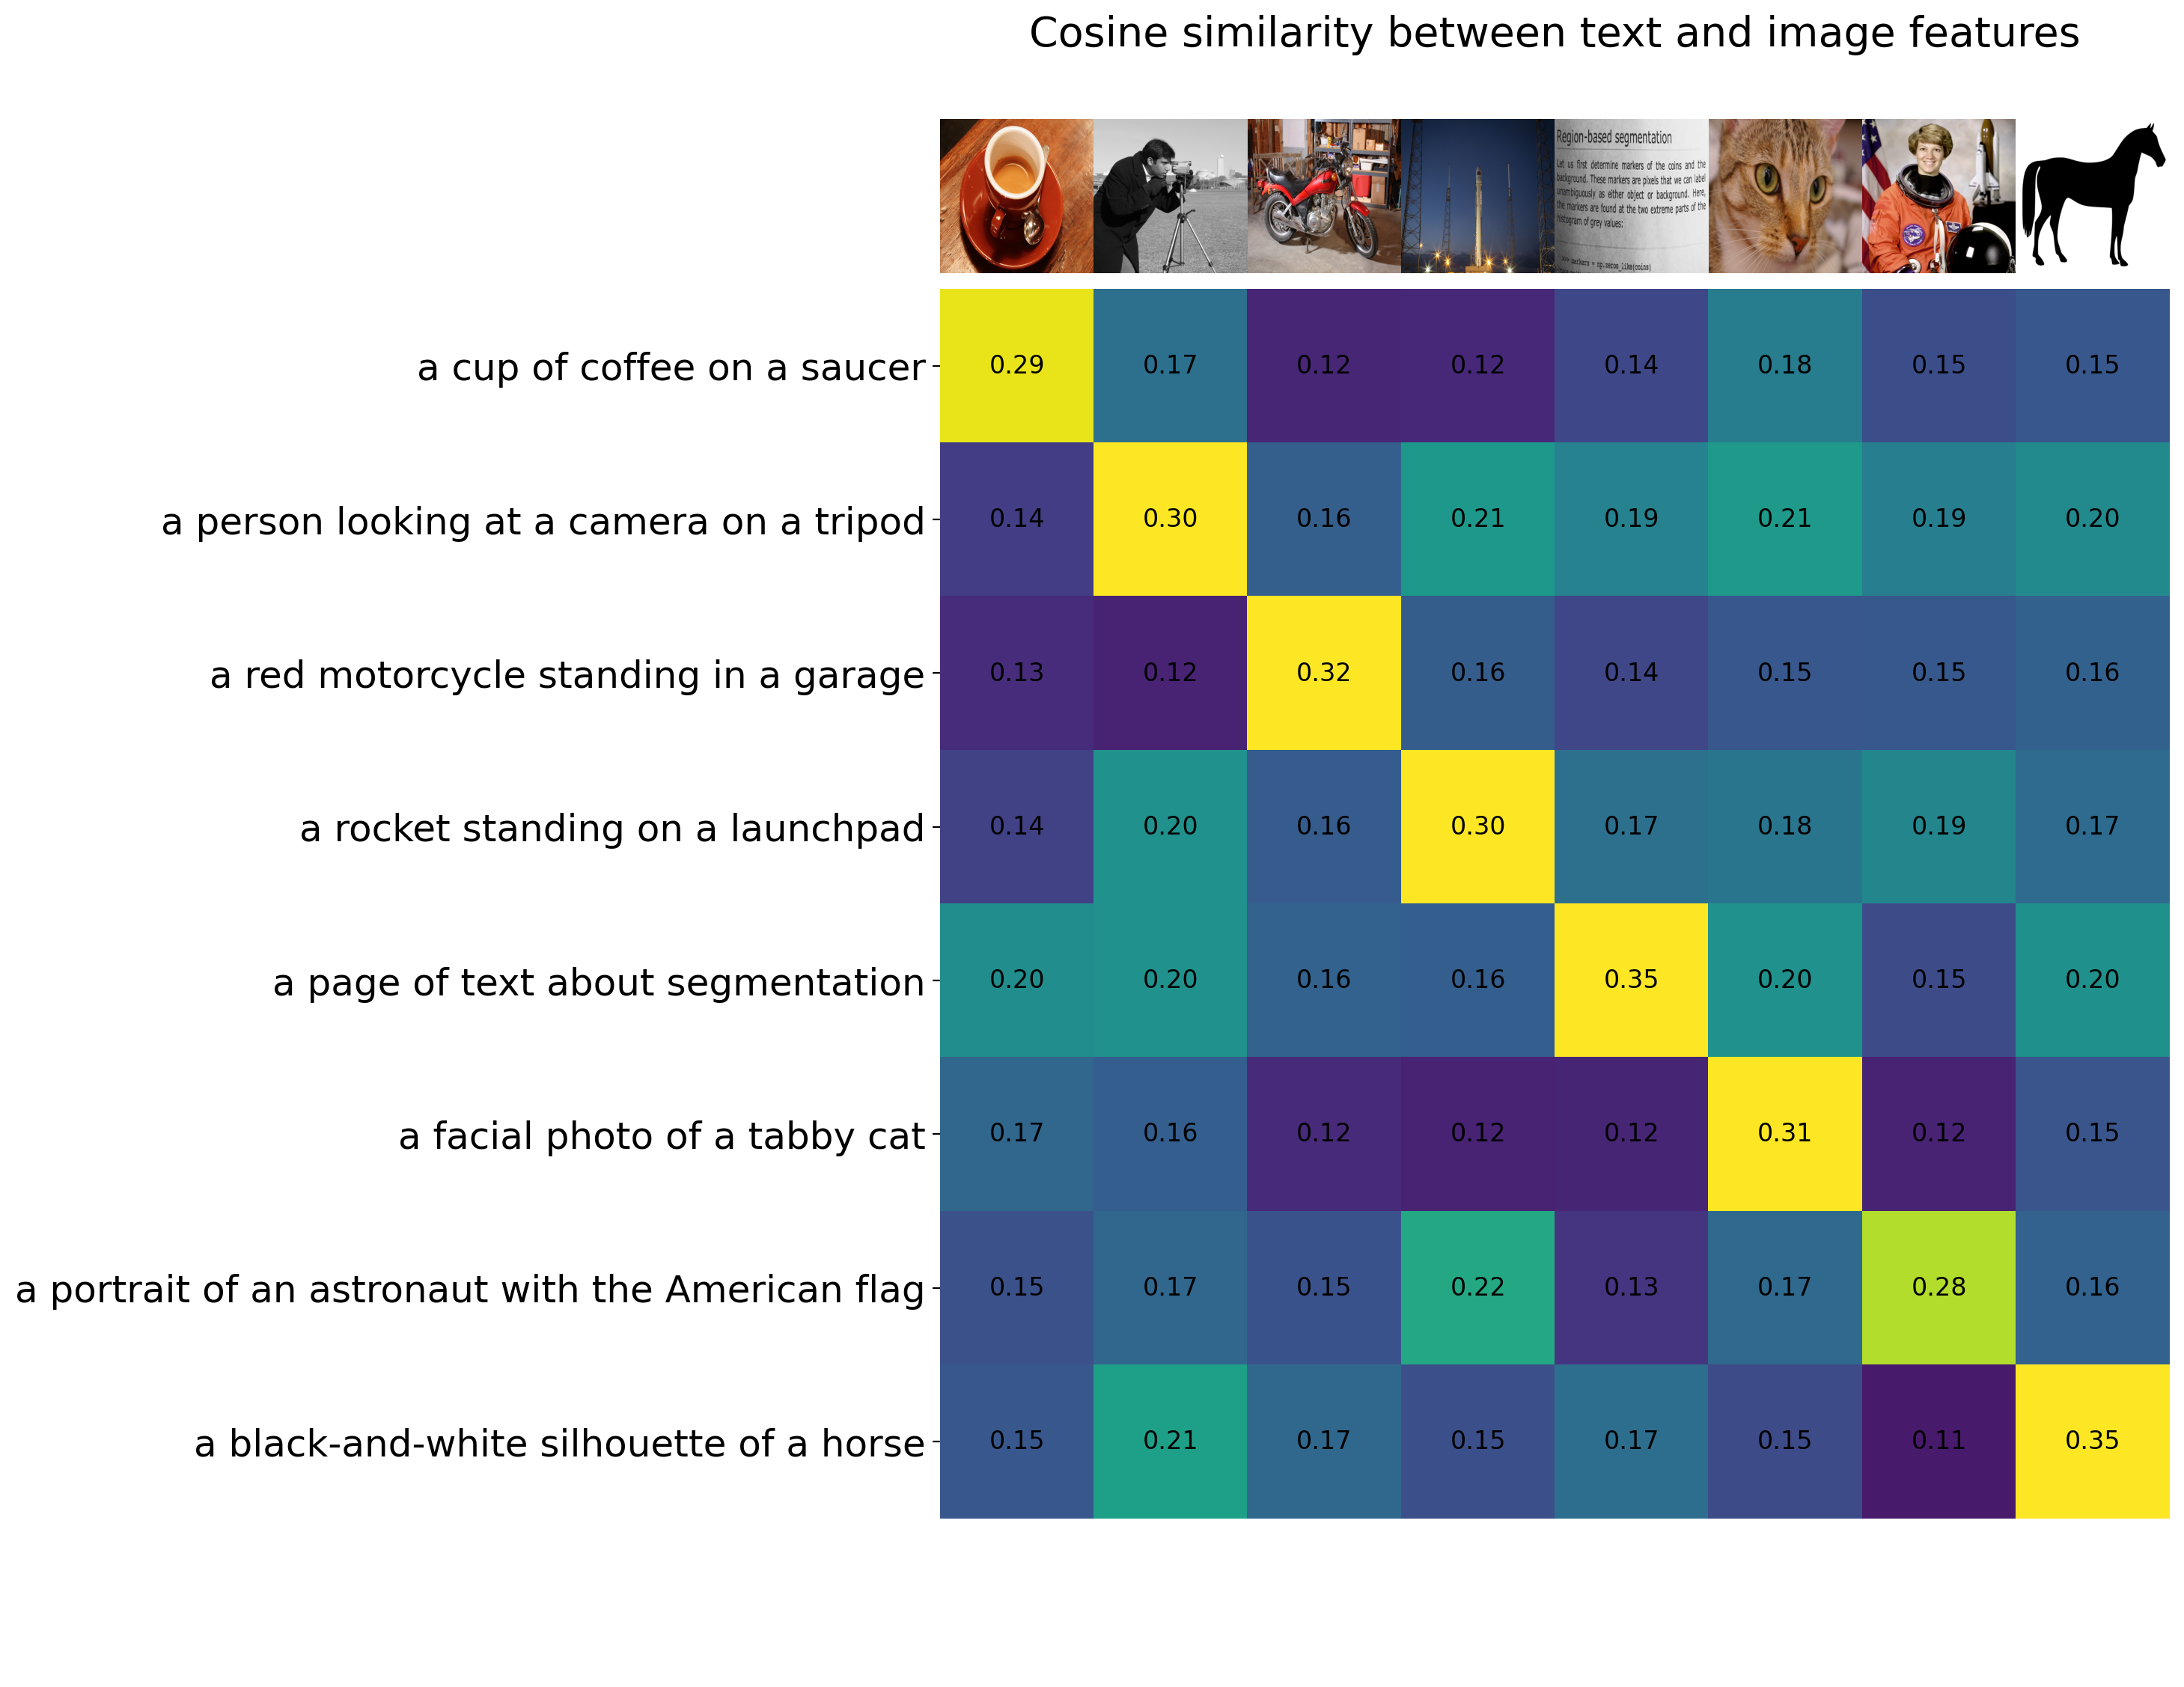

In [ ]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:03<00:00, 47981736.32it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [ ]:
len(text_descriptions),text_features.shape,image_features.shape

(100, torch.Size([100, 512]), torch.Size([8, 512]))

In [ ]:
torch.Tensor([1,3,400,100]).topk(3,dim=-1)

torch.return_types.topk(
values=tensor([400., 100.,   3.]),
indices=tensor([2, 3, 1]))

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#Now it's **experiment** time !!!

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')
path= 'C:\\Users\\smitr\\Downloads\\train'

In [33]:
torch.cuda.empty_cache()

In [9]:
images=[]
for i in range(1,500):
  images.append(preprocess(Image.open(os.path.join(path, f'{i}.png')).convert("RGB")))  
# images.append(preprocess(Image.open(os.path.join(path, 'T_Rex_1.jpg')).convert("RGB")))
# images.append(preprocess(Image.open(os.path.join(path, 'T_Rex_2.jpeg')).convert("RGB")))
# images.append(preprocess(Image.open(os.path.join(path, 'man.jpeg')).convert("RGB")))
# images.append(preprocess(Image.open(os.path.join(path, 'man2.jpeg')).convert("RGB")))


In [10]:
query=[preprocess(Image.open(os.path.join(path, '101.png')).convert("RGB"))]

#Reading images

#Converting them to embeddings

In [11]:
image_input = torch.tensor(np.stack(images)).cuda()
query = torch.tensor(np.stack(query)).cuda()

with torch.no_grad():
    image_embeddings = model.encode_image(image_input).float() 
    query_embeddings = model.encode_image(query).float()    

C:\Users\smitr\anaconda3\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [12]:
image_embeddings.shape,query_embeddings.shape

(torch.Size([499, 512]), torch.Size([1, 512]))

# Now same for texts

In [14]:
# texts=['This is a T-rex roaring','This is a T-rex standing calm',
#        'This is a Lion roaring','This is a honda bike',
#        'A man eating',
#        'A man eating sandwich']

query_text=['This is a frog']
query_text=clip.tokenize(['This is a frog'])
# texts=clip.tokenize(texts)
with torch.no_grad():
#     text_embeddings = model.encode_text(texts.cuda()).float()
    query_text_embedding=model.encode_text(query_text.cuda()).float()


In [16]:
image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)
query_embeddings /= query_embeddings.norm(dim=-1, keepdim=True)
query_text_embedding /= query_text_embedding.norm(dim=-1, keepdim=True)
# text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
# similarity = image_embeddings.cpu().numpy() @ text_embeddings.cpu().numpy().T

In [17]:
(query_embeddings @ image_embeddings.T).topk(k=10)

torch.return_types.topk(
values=tensor([[1.0000, 0.9409, 0.9188, 0.9093, 0.9021, 0.9010, 0.8911, 0.8908, 0.8826,
         0.8811]], device='cuda:0'),
indices=tensor([[100,  62, 222, 353, 216, 192, 244, 309, 365, 221]], device='cuda:0'))

In [18]:
(query_text_embedding  @ image_embeddings.T).topk(k=10)

torch.return_types.topk(
values=tensor([[0.2912, 0.2859, 0.2850, 0.2823, 0.2809, 0.2797, 0.2779, 0.2771, 0.2771,
         0.2731]], device='cuda:0'),
indices=tensor([[292, 355,  25, 245, 452,  19, 409, 361, 187, 243]], device='cuda:0'))

In [19]:
import torch.nn as nn
nn.Softmax(similarity)

Softmax(
  dim=[[0.28927547 0.28526354 0.21975626 0.17922774 0.21536672 0.20256186]
   [0.30441755 0.30475086 0.23733547 0.19096681 0.19512533 0.17911048]
   [0.19398709 0.18748453 0.20509139 0.19311494 0.29026204 0.30801404]]
)

#Let us go on **classification**

In [20]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

possible_labels = [f"This is a photo of a {label}" for label in cifar100.classes]
label_tokens = clip.tokenize(possible_labels).cuda()
with torch.no_grad():
    label_embeddings = model.encode_text(label_tokens).float()

label_embeddings /= label_embeddings.norm(dim=-1, keepdim=True)

100%|██████████| 169001437/169001437 [00:06<00:00, 27173078.89it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [21]:
predicted_labels=(image_embeddings.cpu().numpy() @ label_embeddings.cpu().numpy().T)
predicted_labels=torch.Tensor(predicted_labels).topk(k=5)

In [23]:
print('For Roaring t-rex:')
for cnt,i in enumerate(predicted_labels.indices[0]):
  print(cnt,possible_labels[i])
print('For calm t-rex:')
for cnt,i in enumerate(predicted_labels.indices[1]):
  print(cnt,possible_labels[i])
print('For man:')
for cnt,i in enumerate(predicted_labels.indices[2]):
  print(cnt,possible_labels[i])

For Roaring t-rex:
0 This is a photo of a dinosaur
1 This is a photo of a crocodile
2 This is a photo of a lizard
3 This is a photo of a snake
4 This is a photo of a man
For calm t-rex:
0 This is a photo of a dinosaur
1 This is a photo of a crocodile
2 This is a photo of a lion
3 This is a photo of a bus
4 This is a photo of a man
For man:
0 This is a photo of a man
1 This is a photo of a plate
2 This is a photo of a boy
3 This is a photo of a sweet_pepper
4 This is a photo of a plain


In [ ]:
torch.Tensor([1,2,3]).topk(k=1)

torch.return_types.topk(
values=tensor([3.]),
indices=tensor([2]))

In [ ]:
label_tokens.shape,len(possible_labels)

(torch.Size([100, 77]), 100)

#Now **GPT-2**

#**Rough work**

In [ ]:
a=clip.tokenize('Virat hit a six on a last ball').cuda()
b=clip.tokenize('happy').cuda()

with torch.no_grad():

  a=model.encode_text(a).float()
  b=model.encode_text(b).float()
  c1=a-b



In [ ]:
c=clip.tokenize('once dinosaurs existed on earth like trex, etc.').cuda()
with torch.no_grad():
  c=model.encode_text(c).float()


(c.cpu().numpy()@a.cpu().numpy().T)/(c.norm(dim=-1)*a.norm(dim=-1)).cpu().numpy()

array([[0.7378266]], dtype=float32)

In [ ]:
# image_embeddings[0]
description = " ".join(model.decode_text(image_embeddings[0]))

AttributeError: 'CLIP' object has no attribute 'decode_text'